# Convolutional Neural Networks and Transfer Learning: Classifying Flowers with Keras

## Table of Contents

1. [Introduction](#Introduction)
2. [Dataset Preparation](#Dataset-Preparation)
   - [Downloading the Dataset](#Downloading-the-Dataset)
   - [Resizing Images](#Resizing-Images)
   - [Splitting the Dataset](#Splitting-the-Dataset)
3. [Model Development](#Model-Development)
   - [Customizable VGG16 Transfer Learning Model with Hyperparameter Tuning and Performance Evaluation](#Customizable-VGG16-Transfer-Learning-Model-with-Hyperparameter-Tuning-and-Performance-Evaluation)
   - [Model 1: Freezing VGG16 Layers](#Model-1-Freezing-VGG16-Layers)
   - [Model 2: Unfreezing the Last Block of VGG16](#Model-2-Unfreezing-the-Last-Block-of-VGG16)
   - [Model 3: Unfreezing All Layers](#Model-3-Unfreezing-All-Layers)
4. [Model Comparison, Evaluation, and Conclusion](#Model-Comparison-Evaluation-and-Conclusion)

<a id="Introduction"></a>
## 1. Introduction

In this project, we will explore Convolutional Neural Networks (CNNs) and Transfer Learning by working on a practical project. Our primary focus will be on using the Keras framework to classify different species of flowers. For this, we will use the pre-trained VGG16 model, which has already been trained on a massive dataset of images called ImageNet. By adapting pre-existing neural networks, we can improve the performance and efficiency of our models and explore their potential.<br>

We will begin by preparing the dataset, which involves downloading, resizing, and splitting the images. Next, we will develop three different models with varying degrees of layer freezing for Transfer Learning. Finally, we will thoroughly compare and evaluate these models to see which performs best.

<a id="Dataset-Preparation"></a>
## 2. Dataset Preparation

<a id="Downloading-the-Dataset"></a>
### Downloading the Dataset

In [ ]:
# Ensure TensorFlow is using GPU if available
import tensorflow as tf

# Check if GPU is available and set TensorFlow to use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to only allocate memory as needed on GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Print any errors
        print(e)

# Clear any sessions to avoid resource clutter
tf.keras.backend.clear_session()

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from collections import Counter
from sklearn.model_selection import train_test_split

# TensorFlow and Keras imports for building and training models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D,
    RandomFlip, RandomRotation,
    Input,
    BatchNormalization, Dropout
)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

# Ensure you're using the GPU version of TensorFlow if a GPU is available
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# URL to download the flower dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Download the dataset and extract it
# tf.keras.utils.get_file automatically downloads the dataset, caches it, and extracts it if it's a compressed file
data_dir = tf.keras.utils.get_file(
    fname='flower_photos', # Name for the folder where data will be stored
    origin=dataset_url, # The original URL where the dataset is hosted
    untar=True # Specifies that the downloaded file is a tar file and needs to be extracted
)

# Convert the string path to a pathlib Path object to facilitate directory operations
data_dir = pathlib.Path(data_dir)

# Print the path to confirm it's set correctly
print(f"Data directory path: {data_dir}")

TensorFlow version: 2.15.0
Num GPUs Available: 1
228813984/228813984 [==============================] - 2s 0us/step
Data directory path: /root/.keras/datasets/flower_photos


<a id="Resizing-Images"></a>
### Resizing Images

Found 3670 files belonging to 5 classes.
Total number of samples: 3670
Shape of a single sample: (64, 64, 3)
Unique labels in the dataset: [0 1 2 3 4]


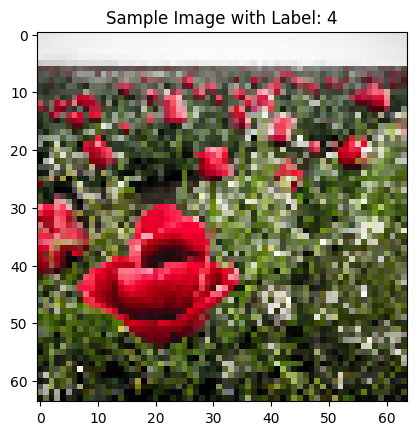

In [ ]:
# Define constants for the batch size and image dimensions
batch_size = 16
img_height = 64
img_width = 64

# Load and resize the images to match the dimensions expected by VGG16
# `image_dataset_from_directory` automatically creates a dataset from image files in a directory
ds_all = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='int', # Labels are encoded as integers (default is 'categorical')
    image_size=(img_height, img_width),
    batch_size=batch_size # Number of images to be yielded from the generator per batch
)

# Normalize the images to have values between 0 and 1
# This is important for neural network models to ensure faster convergence
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

ds_all = ds_all.map(normalize_img)

# Prefetching will load images in the background while the model is training
ds_all = ds_all.prefetch(buffer_size=tf.data.AUTOTUNE)

# Convert the dataset to numpy arrays for easy handling
X_data = []
y_data = []

for images, labels in ds_all.as_numpy_iterator():
    X_data.extend(images)
    y_data.extend(labels)

X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"Total number of samples: {len(X_data)}")
print(f"Shape of a single sample: {X_data[0].shape}")
print(f"Unique labels in the dataset: {np.unique(y_data)}")

# Plot one of the resized and normalized samples
plt.imshow(X_data[0])
plt.title(f"Sample Image with Label: {y_data[0]}")
plt.show()

<a id="Splitting-the-Dataset"></a>
### Splitting the Dataset

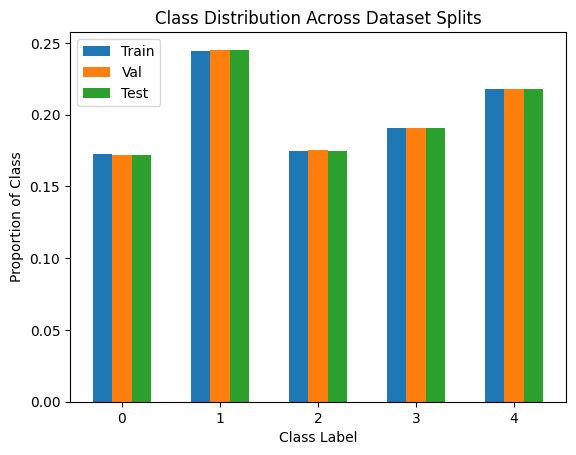

In [ ]:
# Split the dataset into training + validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_data,
    y_data,
    test_size=0.20, # 20% for test set
    random_state=99,
    stratify=y_data # Stratify by y_data to maintain class distribution
)

# Further split the training + validation set into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.20, # 20% of 80% for validation set, effectively 16% of the total data
    random_state=99,
    stratify=y_train_val # Stratify by y_train_val to maintain class distribution
)

def calculate_class_proportions(labels):
    class_counts = Counter(labels)
    total = sum(class_counts.values())
    proportions = {cls: count / total for cls, count in class_counts.items()}
    return proportions

# Calculate class proportions for each dataset split
train_props = calculate_class_proportions(y_train)
val_props = calculate_class_proportions(y_val)
test_props = calculate_class_proportions(y_test)

# Plotting class distribution across dataset splits
classes = sorted(set(y_data))
train_ratios = [train_props.get(cls, 0) for cls in classes]
val_ratios = [val_props.get(cls, 0) for cls in classes]
test_ratios = [test_props.get(cls, 0) for cls in classes]

X_axis = np.arange(len(classes))

plt.bar(X_axis - 0.2, train_ratios, 0.2, label='Train')
plt.bar(X_axis, val_ratios, 0.2, label='Val')
plt.bar(X_axis + 0.2, test_ratios, 0.2, label='Test')

plt.xticks(X_axis, classes)
plt.xlabel("Class Label")
plt.ylabel("Proportion of Class")
plt.title("Class Distribution Across Dataset Splits")
plt.legend()
plt.show()

<a id="Model-Development"></a>
## 3. Model Development

<a id="#Customizable-VGG16-Transfer-Learning-Model-with-Hyperparameter-Tuning-and-Performance-Evaluation"></a>
### Customizable VGG16 Transfer Learning Model with Hyperparameter Tuning and Performance Evaluation

In [ ]:
def build_and_compile_model(input_shape, num_unfreeze_layers, hyperparams):
    # Define the input layer
    input_tensor = Input(shape=input_shape)

    # Load the VGG16 base model
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

    # Set layers to trainable based on num_unfreeze_layers
    if num_unfreeze_layers != 'all':
        for layer in base_model.layers[:-num_unfreeze_layers]:
            layer.trainable = False

    # Create the model
    x = GlobalAveragePooling2D()(base_model.output)
    for _ in range(hyperparams['num_dense_layers']):
        x = Dense(hyperparams['dense_layer_size'], activation=hyperparams['activation'])(x)
        if hyperparams['use_batchnorm']:
            x = BatchNormalization()(x)
        if hyperparams['dropout_rate'] > 0:
            x = Dropout(hyperparams['dropout_rate'])(x)
    output = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    model.compile(optimizer=hyperparams['optimizer'], loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100, batch_size=16):
    early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

    plot_learning_curves(history)

    # Evaluate the model
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0, batch_size=batch_size)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)

    print(f"Train loss: {train_loss}, Train accuracy: {train_acc}")
    print(f"Val loss: {val_loss}, Val accuracy: {val_acc}")
    print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

    return test_acc

<a id="Model-1-Freezing-VGG16-Layers"></a>
### Model 1: Freezing VGG16 Layers

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

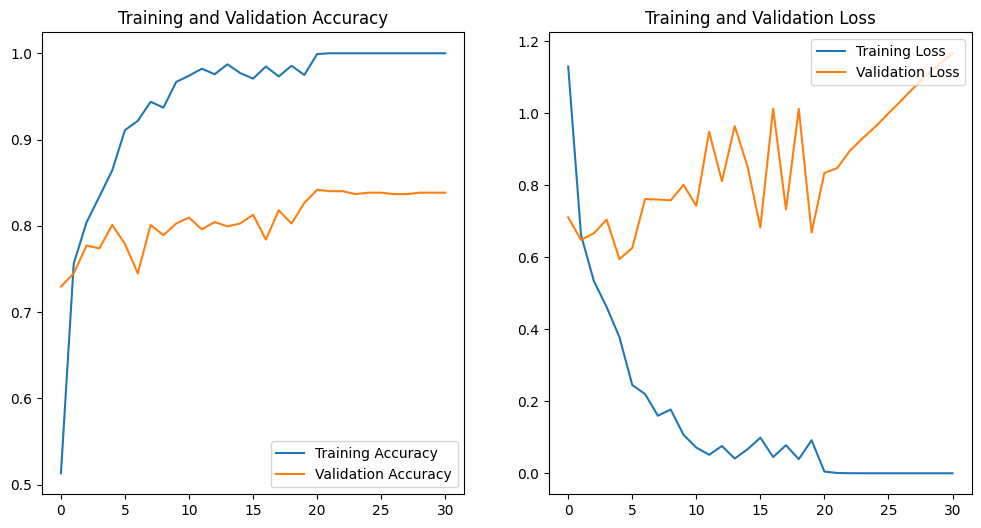

Train loss: 0.0015621482161805034, Train accuracy: 0.9995741248130798
Val loss: 0.8338406085968018, Val accuracy: 0.8418367505073547
Test loss: 0.8381744027137756, Test accuracy: 0.8460490703582764


In [ ]:
# Hyperparameters for Model 1 (A)
hyperparams_model_1_a = {
    'num_dense_layers': 1,
    'dense_layer_size': 256,
    'use_batchnorm': False,
    'dropout_rate': 0.0,
    'activation': 'relu',
    'optimizer': Adam(learning_rate=1e-4),
}

# Build, train, and evaluate Model 1 (A)
model_1_a = build_and_compile_model((64, 64, 3), 0, hyperparams_model_1_a)  # Freeze all VGG16 layers
test_acc_1_a = train_and_evaluate_model(model_1_a, X_train, y_train, X_val, y_val, X_test, y_test)

The model achieved exceptional training performance with a loss of just 0.0016 and an accuracy of nearly 99.96%, indicating it has almost perfectly learned the training dataset. However, the increase in validation and test losses to approximately 0.834 suggests the model may be overfitting, as it doesn't generalize as well to unseen data. Despite this, the test accuracy remains high at 84.60%, showing that the model is still capable of making accurate predictions on new data.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

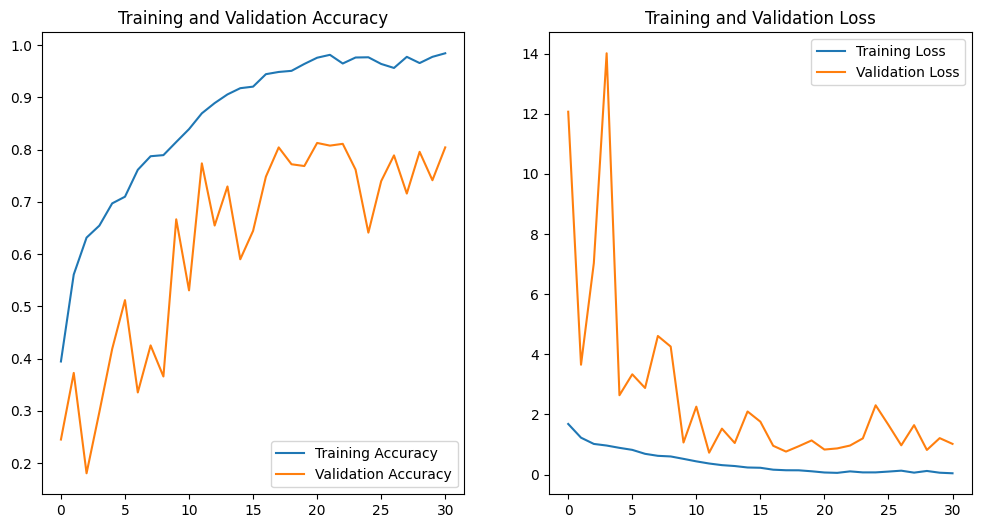

Train loss: 0.011975081637501717, Train accuracy: 0.9965928196907043
Val loss: 0.8315547108650208, Val accuracy: 0.8129251599311829
Test loss: 0.7707639932632446, Test accuracy: 0.8392370343208313


In [ ]:
# Hyperparameters for Model 1 (B)
hyperparams_model_1_b = {
    'num_dense_layers': 2, # Increasing the number of dense layers to add model capacity
    'dense_layer_size': 512, # Increasing the size of dense layers to capture more complex representations
    'use_batchnorm': True, # Introducing batch normalization to improve training stability
    'dropout_rate': 0.25, # Introducing dropout for regularization to reduce overfitting
    'activation': 'relu',
    'optimizer': Adam(learning_rate=1e-4), # Keeping the learning rate the same for now to isolate the effects of other changes
}

# Build, train, and evaluate Model 1 (B)
model_1_b = build_and_compile_model((64, 64, 3), 0, hyperparams_model_1_b)  # Freeze all VGG16 layers
test_acc_1_b = train_and_evaluate_model(model_1_b, X_train, y_train, X_val, y_val, X_test, y_test)


The training results show a low loss of 0.012 and a high accuracy of nearly 99.66%, indicating the model has learned the training set effectively. However, the significant gap between training and validation/test loss suggests potential overfitting, as the model may not perform as well on data it hasn't seen before. Nonetheless, the model demonstrates a strong ability to generalize, with a test accuracy of 83.92%, which is commendable despite the observed overfitting indicators.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

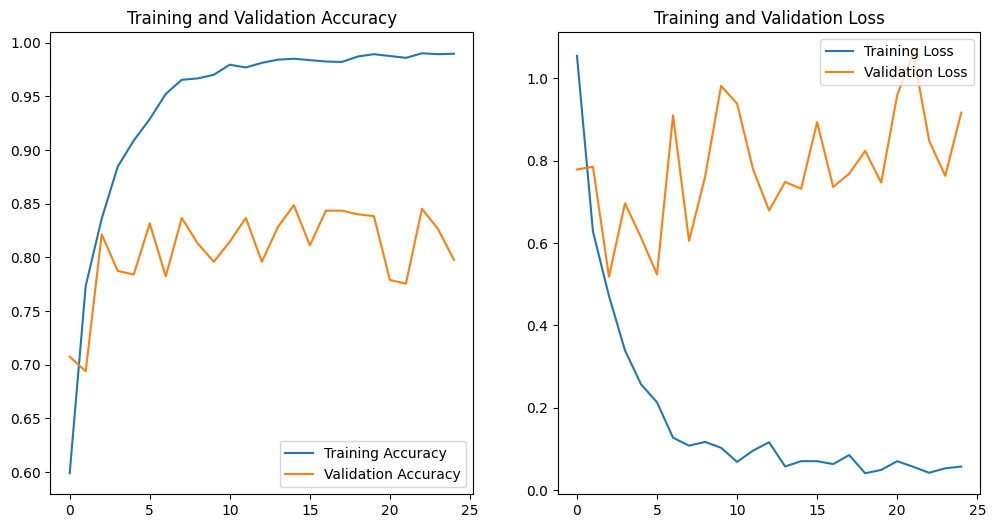

Train loss: 0.001962421927601099, Train accuracy: 1.0
Val loss: 0.7316808104515076, Val accuracy: 0.8486394286155701
Test loss: 0.6960574984550476, Test accuracy: 0.8610354065895081


In [ ]:
# Hyperparameters for Model 1 (C)
hyperparams_model_1_c = {
    'num_dense_layers': 1, # Keeping the model simpler to see if we can maintain performance with less capacity
    'dense_layer_size': 256, # Keeping the original size
    'use_batchnorm': False, # Removing batch normalization to simplify the model
    'dropout_rate': 0.0, # Removing dropout to see the effect of simplification
    'activation': 'elu', # Changing activation function to ELU for potentially better performance
    'optimizer': RMSprop(learning_rate=5e-5), # Changing optimizer to RMSprop for a different optimization approach and lowering the learning rate to allow more fine-grained updates
}

# Build, train, and evaluate Model 1 (C)
model_1_c = build_and_compile_model((64, 64, 3), 0, hyperparams_model_1_c)  # Freeze all VGG16 layers
test_acc_1_c = train_and_evaluate_model(model_1_c, X_train, y_train, X_val, y_val, X_test, y_test)

The model achieved perfect training accuracy of 100% with an exceptionally low train loss of 0.00196, indicating it has mastered the training data completely. However, the increase in validation and test loss points to a discrepancy between its performance on the training data versus unseen data, hinting at overfitting. Impressively, the model still secures a strong test accuracy of 86.10%, showcasing its robust predictive capabilities on new data despite the potential overfitting challenge.

<a id="Model-2-Unfreezing-the-Last-Block-of-VGG16"></a>
### Model 2: Unfreezing the Last Block of VGG16

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

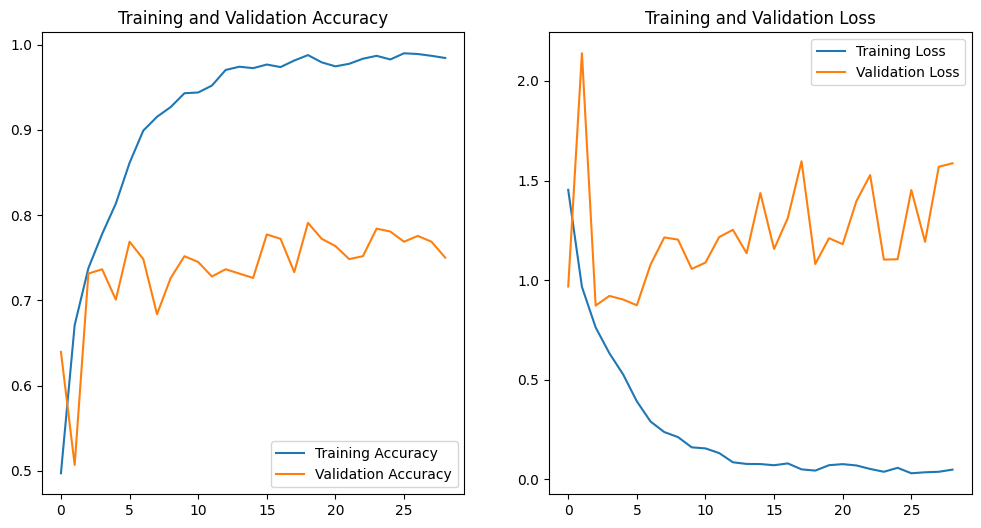

Train loss: 0.013111227191984653, Train accuracy: 0.9953151345252991
Val loss: 1.0806961059570312, Val accuracy: 0.7908163070678711
Test loss: 1.138464331626892, Test accuracy: 0.8024523258209229


In [ ]:
# Hyperparameters for Model 2
hyperparams_model_2 = {
    'num_dense_layers': 2,
    'dense_layer_size': 512,
    'use_batchnorm': True,
    'dropout_rate': 0.3,
    'activation': 'relu',
    'optimizer': Adam(learning_rate=1e-4),
}

# Build, train, and evaluate Model 2
model_2 = build_and_compile_model((64, 64, 3), 4, hyperparams_model_2)  # Unfreeze the last block (4 layers)
test_acc_2 = train_and_evaluate_model(model_2, X_train, y_train, X_val, y_val, X_test, y_test)

The training performance is impressive, with a low loss of 0.013 and a high accuracy of 99.53%, indicating that the model has effectively learned from the training data. However, the significant increase in validation and test loss suggests a challenge in generalizing the learned patterns to new, unseen data, possibly indicating overfitting. Despite this, the model maintains a decent level of accuracy on the test set at 80.25%, showing it retains a good measure of predictive power when faced with new examples.

<a id="Model-3-Unfreezing-All-Layers"></a>
### Model 3: Unfreezing All Layers

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

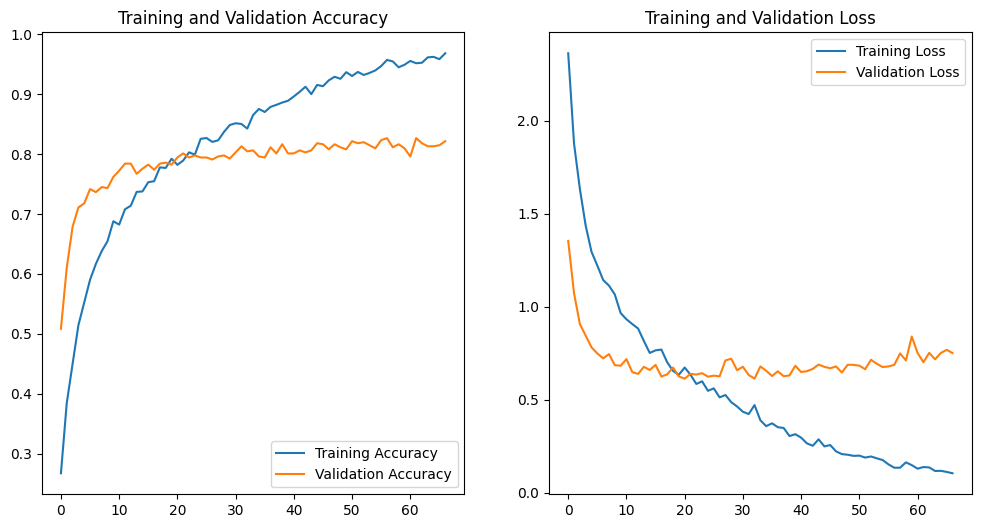

Train loss: 0.0221867635846138, Train accuracy: 0.9970187544822693
Val loss: 0.6868014335632324, Val accuracy: 0.8265306353569031
Test loss: 0.6879294514656067, Test accuracy: 0.8215258717536926


In [ ]:
# Hyperparameters for Model 3
hyperparams_model_3 = {
    'num_dense_layers': 2,
    'dense_layer_size': 512,
    'use_batchnorm': True,
    'dropout_rate': 0.5, # Increasing dropout rate for more regularization
    'activation': 'elu', # Trying a different activation function
    'optimizer': SGD(learning_rate=1e-4), # Switching to SGD for finer control
}

# Build, train, and evaluate Model 3
model_3 = build_and_compile_model((64, 64, 3), 'all', hyperparams_model_3)  # Unfreeze all layers
test_acc_3 = train_and_evaluate_model(model_3, X_train, y_train, X_val, y_val, X_test, y_test)


The model showcases excellent learning on the training set with a very low loss of 0.022 and an impressive accuracy of 99.70%, demonstrating its ability to almost perfectly capture the training data's underlying patterns. The rise in validation and test loss, although relatively moderate, points towards a slight overfitting issue, where the model performs less optimally on unseen data compared to the training set. Nevertheless, the model achieves strong test accuracy of 82.15%, indicating a robust ability to generalize and make accurate predictions on new, unseen data despite the slight overfitting.

<a id="Model-Comparison-Evaluation-and-Conclusion"></a>
## 4. Model Comparison, Evaluation, and Conclusion

In [ ]:
model_accuracies = {
    'Model 1 (A)': {'Test Accuracy': test_acc_1_a},
    'Model 1 (B)': {'Test Accuracy': test_acc_1_b},
    'Model 1 (C)': {'Test Accuracy': test_acc_1_c},
    'Model 2': {'Test Accuracy': test_acc_2},
    'Model 3': {'Test Accuracy': test_acc_3},
}

accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index').round(2)

formatted_df = accuracies_df.style.format("{:.2f}%").set_caption("Test Accuracy Across Different Models")
formatted_df = formatted_df.highlight_max(color='lightgreen')

formatted_df

,Test Accuracy
Model 1 (A),0.85%
Model 1 (B),0.84%
Model 1 (C),0.86%
Model 2,0.80%
Model 3,0.82%


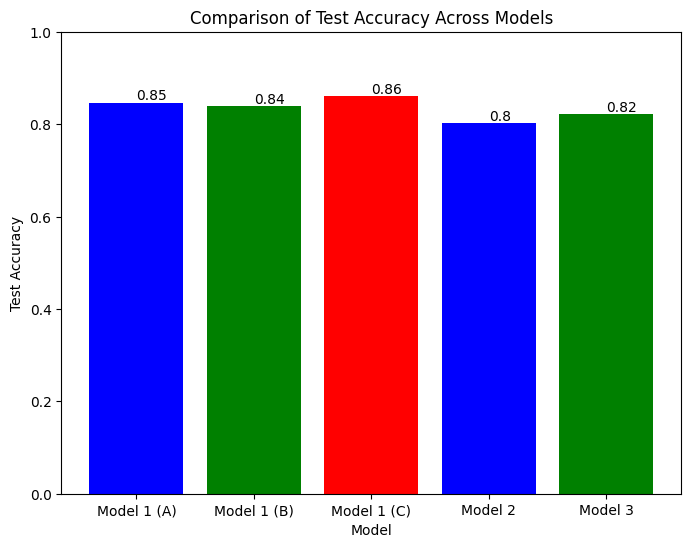

In [ ]:
# Extract model names and their test accuracies
models = list(model_accuracies.keys())
test_accuracies = [model_accuracies[model]['Test Accuracy'] for model in models]

# Create a bar chart
plt.figure(figsize=(8, 6))  # Set the figure size for better readability
bars = plt.bar(models, test_accuracies, color=['blue', 'green', 'red'])

# Adding the aesthetics
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracy Across Models')
plt.ylim(0, 1)  # Set the limit for the Y-axis to make the chart clearer

# Adding the exact accuracy values on top of the bars for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval,2), va='bottom')  # va: vertical alignment

# Show the plot
plt.show()

The data and hyperparameter details provided offer a comprehensive insight into the performance and configuration of various machine learning models aimed at a classification task.

Model 1 Variants (A, B, C) show close performance with Test Accuracies of 0.85%, 0.84%, and 0.86% respectively. These variations indicate minor adjustments in the model's architecture and hyperparameters can lead to differences in performance, albeit slight.

Model 2 has a Test Accuracy of 0.80%, which is lower than all variants of Model 1. This suggests that the changes made in Model 2 did not positively affect its ability to generalize to unseen data.

Model 3 shows a slight improvement over Model 2 with a Test Accuracy of 0.82%, yet still falls short of Model 1's performance. This might imply that while the adjustments in Model 3 moved in the right direction, they were not sufficient to outperform Model 1.<br>
Model 1 (A) is the baseline model with a simple configuration. It uses a single dense layer without batch normalization or dropout, and the Adam optimizer with a learning rate of 1e-4.

Model 1 (B) introduces significant changes aimed at increasing model capacity and reducing overfitting, such as adding an extra dense layer, increasing layer size, introducing batch normalization, and incorporating dropout. Despite these efforts, its performance slightly trails behind Model 1 (A), suggesting that the increase in complexity didn't necessarily translate to better generalization.

Model 1 (C) takes a different approach by simplifying the model (reducing the number of dense layers and removing batch normalization and dropout) and changing the activation function and optimizer. Interestingly, this version achieves the highest Test Accuracy among the Model 1 variants, indicating that for this specific task, a simpler model with carefully chosen hyperparameters can perform effectively.

Model 2 shares some hyperparameters with Model 1 (B) but differs in the approach to unfreezing layers, which doesn't seem to benefit the model's performance, suggesting that the choice of which layers to train can significantly impact the outcome.

Model 3 attempts a more aggressive regularization strategy with a higher dropout rate and switches both the activation function and optimizer. Despite these changes aiming to improve model generalization, it does not surpass the performance of Model 1 variants, hinting at the possibility that too much regularization might be detrimental or that the choice of optimizer and activation function was not optimal for this task.

The comparative analysis of these models underscores the intricate balance between model complexity, regularization, and the choice of hyperparameters in achieving optimal performance. Model 1 (C)'s superior performance, despite its simplicity, highlights the importance of matching model complexity to the task at hand and the potential benefits of experimenting with different optimizers and activation functions. Meanwhile, the relatively lower performance of Models 2 and 3 despite more complex strategies suggests that more is not always better, and the effectiveness of unfreezing layers or increasing dropout rates can vary significantly depending on the specific characteristics of the data and task.